# House Prices: Advanced Regression Techniques - Model 2

## Content
- 1. Problem Statement
- 2. Data Cleaning
- 3. Impute Missing Values
- 4. Identify Ordinal and Nominal Categorical Features
- 5. Encode Ordinal Categorical Features
- 6. Feature Engineering
- 7. Log Transformation
- 8. Encode Nominal Features
- 9. Robust Scaling
- 10. Modelling

# 1. Problem Statement
- **Build a regression model to predict the sales price for each house in Ames, Iowa**

In [1]:
# Import the treasures
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For comparison with normal distribution when plotting graph
from scipy.stats import norm, skew

# Encoder
from sklearn.preprocessing import LabelEncoder

# Normal Distribution Transformer
from scipy.special import boxcox1p

# Scaler
from sklearn.preprocessing import RobustScaler

# GridSearch
from sklearn.model_selection import GridSearchCV

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Make the graphs generated by matplotlib appear instead of object
%matplotlib inline

pd.set_option('display.max_columns', 500)

# 2. Data Cleaning

In [2]:
# Load the Data
train = pd.read_csv('./house_train.csv')
test = pd.read_csv('./house_test.csv')

# Drop the Id column for both train and test
train.drop("Id", axis=1, inplace=True)
test_ID = test['Id']
test.drop("Id", axis=1, inplace=True)

## 2.1 Remove Outliers
- Remove outliers identified in Model 1

In [3]:
# Drop outliers identified
train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index, inplace=True)

# Drop Data with GarageCars 4 or more
train.drop(train[(train['GarageCars'] > 3)].index, inplace=True)

# Drop Data with TotRmsAbvGrd = 14
train.drop(train[(train['TotRmsAbvGrd'] == 14)].index, inplace=True)

In [4]:
# Get the Target - SalePrice
y = np.log1p(train['SalePrice'])
train.drop("SalePrice", axis=1, inplace=True)

# 3. Impute Missing Values

In [5]:
# Get an Overview for all Missing Values for All Data, but impute separately
all_data = pd.concat([train,test], axis=0)
total = all_data.isnull().sum()
percent = (total / all_data.shape[0]) * 100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.drop(missing_data[missing_data['Total'] == 0].index).sort_values('Total',ascending=False)

,Total,Percent
PoolQC,2902,99.690828
MiscFeature,2806,96.392992
Alley,2715,93.266919
Fence,2341,80.419100
FireplaceQu,1416,48.643078
LotFrontage,485,16.660941
GarageFinish,158,5.427688
GarageQual,158,5.427688
GarageCond,158,5.427688
GarageYrBlt,158,5.427688


In [6]:
# Fill the most sensible missing value for each feature for both Train and Test

# PoolQC: If NA, the house has No Pool -> Fill with None
train['PoolQC'].fillna('None', inplace=True)
test['PoolQC'].fillna('None', inplace=True)

# MiscFeature: If NA, the house has no MiscFeature -> Fill with None
train['MiscFeature'].fillna('None', inplace=True)
test['MiscFeature'].fillna('None', inplace=True)

# Alley: If NA, the house has no Alley access -> Fill with None
train['Alley'].fillna('None', inplace=True)
test['Alley'].fillna('None', inplace=True)

# Fence: If NA, the house has no Fence -> Fill None
train['Fence'].fillna('None', inplace=True)
test['Fence'].fillna('None', inplace=True)

# FireplaceQu: If NA, the house has no Fireplace -> Fill None
train['FireplaceQu'].fillna('None', inplace=True)
test['FireplaceQu'].fillna('None', inplace=True)

# LotFrontage: Linear feet of street connected to property
# Houses in the same neighborhood should have similar design -> Fill with median of Neighborhood
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
# Reference: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

# GarageType, GarageFinish, GarageQual and GarageCond：If NA, means no Garage -> Fill with None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col].fillna('None', inplace=True)
    test[col].fillna('None', inplace=True)
    
# GarageYrBlt, GarageArea and GarageCars: If NA, mean no Garage -> Fill with 0
# It might be counter-intuitive to fill GarageYrBlt with 0, but to model, it does not matter
# The model will be able to categorize all the houses without a garage to be built on year "0"
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train[col].fillna(0, inplace=True)
    test[col].fillna(0, inplace=True)

# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath
# If NA, means no basement/no basement bath -> Fill with 0
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train[col].fillna(0, inplace=True)
    test[col].fillna(0, inplace=True)

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2  
# If NA, means no basement -> Fill with None
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train[col].fillna('None', inplace=True)
    test[col].fillna('None', inplace=True)

# MasVnrArea: If NA, means no masonry veneer -> Fill with 0
train["MasVnrArea"].fillna(0, inplace=True)
test["MasVnrArea"].fillna(0, inplace=True)

# MasVnrType: If NA, means no masonry veneer -> Fill with None
train["MasVnrType"].fillna("None", inplace=True)
test["MasVnrType"].fillna("None", inplace=True)

# MSZoning, Functional, Electrical, KitchenQual, Exterior1st, Exterior2nd, SaleType: 
# All these features have just 1 or 2 missing values, fill with the most common
for col in ('MSZoning', 'Functional', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType'):
    train[col].fillna(train[col].mode()[0], inplace=True)
    test[col].fillna(test[col].mode()[0], inplace=True)

# Utilities: For this feature, there is only 1 house with 'NoSeWa' which is in training set
# The rest of the houses are all 'AllPub' in test set
# Hence this variable will not help with the prediction
train.drop(['Utilities'], axis=1, inplace=True)
test.drop(['Utilities'], axis=1, inplace=True)

#Check if there are anymore missing values
print("Missing Values Left: ", train.isnull().values.sum() + test.isnull().values.sum())

Missing Values Left:  0


# 4. Identify Ordinal and Nominal Features
- Referencing data dictionary, go through feature by feature to identify ordinal and nominal features

In [7]:
num_ordinal = ['MSSubClass', 'OverallQual', 'OverallCond','YearBuilt', 'YearRemodAdd', 
               'GarageCars', 'GarageYrBlt', 'TotRmsAbvGrd', 'BedroomAbvGr', 'FullBath', 'HalfBath',
               'BsmtFullBath', 'BsmtHalfBath', 'KitchenAbvGr', 'Fireplaces', 'MoSold', 'YrSold']

obj_ordinal = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
               'FireplaceQu', 'GarageQual', 'GarageCond', 'GarageFinish', 'ExterQual', 
               'ExterCond', 'HeatingQC', 'PoolQC', 'KitchenQual', 'LandSlope', 'LotShape', 
               'PavedDrive', 'Street', 'Alley', 'Fence', 'Functional'] 

obj_nominal = ['LandContour', 'CentralAir', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2', 
               'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
               'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 
                'SaleType', 'SaleCondition', 'LotConfig']

# Double check the remaining are all numeric features
for col in train.columns:
    if col not in (num_ordinal + obj_ordinal + obj_nominal):
        print(col, end=", ")

LotFrontage, LotArea, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, 

# 5. Encode Ordinal Categorical Features
- Retain the information in the order of the categories
- Numeric Ordinal features do not need to be encoded

In [8]:
# Concatenate for convenience of encoding and feature engineering only
all_data = pd.concat([train,test], axis=0)

all_data = all_data.replace({
    "BsmtQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "BsmtExposure" : {"None" : 0, "No" : 1, "Mn" : 2, "Av": 3, "Gd" : 4},
    "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
    "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
    "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "GarageFinish": {"None" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3},
    "ExterQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "ExterCond" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
    "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
    "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
    "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
    "Street" : {"Grvl" : 1, "Pave" : 2},
    "Alley" : {"None" : 0, "Grvl" : 1, "Pave" : 2},
    "Fence" : {"None" : 0, "MnWw" : 1, "MnPrv" : 1, "GdWo" : 2, "GdPrv" : 2},
    "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 3, "Mod": 4, "Min2" : 5, "Min1" : 5, "Typ" : 6}
})

# 6. Feature Engineering
## 6.1 Generation of New Features

In [9]:
# Overall quality of the house
all_data["OverallGrade"] = all_data["OverallQual"] * all_data["OverallCond"]

# Overall quality of the garage
all_data["GarageGrade"] = all_data["GarageQual"] * all_data["GarageCond"]

# Overall quality of the exterior
all_data["ExterGrade"] = all_data["ExterQual"] * all_data["ExterCond"]

# Overall kitchen score
all_data["KitchenScore"] = all_data["KitchenAbvGr"] * all_data["KitchenQual"]

# Overall fireplace score
all_data["FireplaceScore"] = all_data["Fireplaces"] * all_data["FireplaceQu"]

# Overall garage score
all_data["GarageScore"] = all_data["GarageArea"] * all_data["GarageQual"]

# Overall pool score
all_data["PoolScore"] = all_data["PoolArea"] * all_data["PoolQC"]

# Total SF for house (incl. basement)
all_data["TotalArea"] = all_data["1stFlrSF"] + all_data['2ndFlrSF'] + all_data["TotalBsmtSF"]

# Total number of bathrooms
all_data["TotalBath"] = all_data["FullBath"] + (0.5 * all_data["HalfBath"]) + \
                        all_data["BsmtFullBath"] + (0.5 * all_data["BsmtHalfBath"])

# Total SF for porch
all_data["AllPorchSF"] = all_data["OpenPorchSF"] + all_data["EnclosedPorch"] + \
                        all_data["3SsnPorch"] + all_data["ScreenPorch"]

# A feature that considers both Area and Quality of house
all_data["Overall"] = all_data["TotalArea"] * all_data["OverallGrade"]

## 6.2 Polynomial Regression Features

In [10]:
train = all_data[:train.shape[0]]
train_corr = pd.concat([train, y], axis=1)

# Get the top 10 features which have the highest correlation with SalePrice
corr = train_corr.corr()
poly_cols = corr['SalePrice'].sort_values(ascending = False)[1:11].index

# Generate the Polynomial Features
# Square root and Square are two likely functions that relate feature with SalePrice
# Considering the shape of x^2 and sqrt(x) graphs
for col in poly_cols:
    all_data[col + "-Square"] = all_data[col] ** 2
    all_data[col + "-Sqrt"] = np.sqrt(all_data[col])

# 7. Box-Cox Transformation of Numeric Features
- A Box Cox transformation is a way to **transform non-normal dependent variables into a normal shape**
<hr>
- Transformation **based on skewness of Train data only**
- **In reality, after model is built, we can only log the features in Test data based on which features in Train data were logged when we were building the model**

In [11]:
train = all_data[:train.shape[0]]
test = all_data[train.shape[0]:]

# Select all the numeric features 
num_feats = train.select_dtypes(exclude='object').columns

# Calculate the skewness of each num feature
skewness = train[num_feats].apply(lambda x : skew(x)).sort_values(ascending=False)

# Get columns with skewness > 0.5
skew_feats = skewness[abs(skewness) > 0.5].index

# Apply BoxCox Transformation to those with skewness > 0.5
for col in skew_feats:
    train[col] = boxcox1p(train[col], 0.15)
    test[col] = boxcox1p(test[col], 0.15)
# Reference: https://www.kaggle.com/ashirahama/blending?scriptVersionId=6250764 

# 8. Encode Nominal Features

In [12]:
all_data = pd.concat([train,test], axis=0)
all_data = pd.get_dummies(all_data)

train = all_data[:train.shape[0]]
test = all_data[train.shape[0]:]

print(train.shape)
print(test.shape)

(1452, 251)
(1459, 251)


# 9. Robust Scaling

In [13]:
#RobustScaler
scaler = RobustScaler()
X = scaler.fit_transform(train)
X_test = scaler.transform(test)

# 10. Modelling

In [14]:
#Scorer & Cross-Validation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

#Models
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

In [15]:
#Cross-Validation function
n_folds = 10
scorer = "neg_mean_squared_error" #Use this scorer for convenience to submit to Kaggle

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=33)
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring=scorer, cv=kf))
    return(rmse)

## 10.1 Lasso - L1 Regularization

In [16]:
lasso = LassoCV(alphas=[0.00031,0.00032,0.00033,0.00034,0.00035,0.00036,0.00037,0.00038,0.00039], max_iter=50000, cv=10)
lasso.fit(X, y)
print("Best Alpha:", lasso.alpha_)
print("Lasso score: {:.4f}".format(rmsle_cv(lasso).mean()))

Best Alpha: 0.00037
Lasso score: 0.1081


Comment:
- Wow, the score improved by so much

Lasso picked 107 features
Lasso elminated 144 features


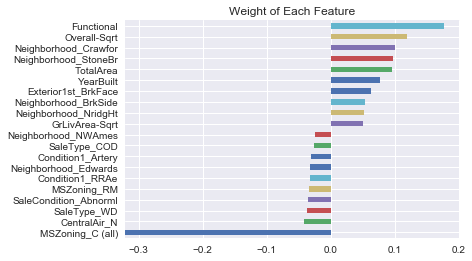

In [17]:
#Visualize the features picked by Lasso
coefs = pd.Series(lasso.coef_, index = train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features")
print("Lasso elminated " + str(sum(coefs == 0)) + " features")

imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Weight of Each Feature")

Comment:
- Surprisingly, **Functional affects the SalePrice the most**
    - Functional - Indicates Home functionality, which is a ordinal cat feature
    <hr>
- **Overall-Sqrt** - Polynomial Regression at work
    - Overall is a feature engineered, trying to **describe both the Area and Condition of a house**
    - The **SalePrice follows a square root function as Overall changes** which makes sense, sqrt function increase less fast as x gets bigger
    - Square function will decrease after peaking
     <hr>
- **Neighborhood** - yes, of course
 <hr>
- **SaleType & SaleCondition** - Logical. Nobody want to buy a house with problematic administration
 <hr>
- **CentralAir_N** - Logical. Nobody likes a house without air-con, especially it is pretty hot in Ames during Summer
 <hr>
- **MSZoning_C** - Apparently, nobody like their house in commercial zone
    - As Singaporean, I don't mind staying in Orchard, but maybe Americans do not like it
    - Or Ame's commerical zone is just bad

## 10.2 Ridge - L2 Regularization

In [18]:
ridge = RidgeCV(alphas=[5,6,7,8,8.1,8.2,8.3,8.4,8.5,8.6,8.7,8.8,8.9,9,10,11,12,13])
ridge.fit(X, y)
print("Best Alpha:", ridge.alpha_)
print("Lasso score: {:.4f}".format(rmsle_cv(ridge).mean()))

Best Alpha: 8.3
Lasso score: 0.1108


Ridge picked 251 features
Ridge elminated 0 features


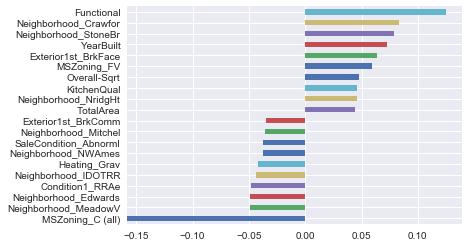

In [19]:
coefs = pd.Series(ridge.coef_, index = train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features")
print("Ridge elminated " + str(sum(coefs == 0)) + " features")

imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")

## 10.4 Kernel Ridge
- Kernel ridge regression (KRR) combines Ridge Regression (linear least squares with l2-norm regularization) with the kernel trick

In [20]:
KRR = KernelRidge(alpha=8, kernel='polynomial', degree=2, coef0=12)

print("Kernel Ridge score: {:.4f}".format(rmsle_cv(KRR).mean()))

KRR.fit(X,y)

Kernel Ridge score: 0.1165


KernelRidge(alpha=8, coef0=12, degree=2, gamma=None, kernel='polynomial',
      kernel_params=None)

## 10.3 Gradient Boosting Regression

In [21]:
# Hyperparameter tuning takes very very very long
# Got the parameters from this kernel: https://www.kaggle.com/ashirahama/blending?scriptVersionId=6250764
# Might not be the best but usable

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

print("Gradient Boosting score: {:.4f}".format(rmsle_cv(GBoost).mean()))

GBoost.fit(X,y)

Gradient Boosting score: 0.1129


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             n_iter_no_change=None, presort='auto', random_state=5,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

## 10.4 XGBoost
- XGB is a Gradient Boosted Decision Trees model which trains a model and calculates the error
    - The **error is used to build next model to predict the error**
    - The previous model is added into the ensemble of models; **collection of error-predicting models**
    - In this way, a cycle is formed to develop the model with least error

In [22]:
xgb_model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

print("Xgboost score: {:.4f}".format(rmsle_cv(xgb_model).mean()))

xgb_model.fit(X,y)

Xgboost score: 0.1132


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05,
       max_delta_step=0, max_depth=3, min_child_weight=1.7817,
       missing=None, n_estimators=2200, n_jobs=1, nthread=-1,
       objective='reg:linear', random_state=7, reg_alpha=0.464,
       reg_lambda=0.8571, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.5213)

## 10.5 Kaggle Submission

In [23]:
prediction = (np.expm1(lasso.predict(X_test)) + np.expm1(ridge.predict(X_test)) + \
                np.expm1(GBoost.predict(X_test)) + np.expm1(xgb_model.predict(X_test)) \
             + np.expm1(KRR.predict(X_test))) / 5
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = prediction
submission.to_csv('submission_house_model_2.csv',index=False)

# 11. Conclusion
![title](./Housing_V2_Kaggle_Score.JPG)
- Well Done Regularization Models!!!
- Best for dataset with so many features!!!